# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Rander metrics

In this notebook, we solve Rander eikonal equations on the CPU and the GPU, and check that they produce consistent results.

*Note on the numerical schemes*: The numerical schemes solved by the CPU and GPU in the Rander case are entirely different. The CPU version uses a causal semi-Lagrangian scheme, two dimensional only, whereas the GPU version uses a non-causal (yet monotone) Eulerian scheme, in two and three dimensions.

In [1]:
large_instances = False # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 
anisotropy_bound = 20. if strong_anisotropy else 5. # Ratio between the fastest and the smallest velocity at any given point

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Constant metric](#1.1-Constant-metric)
    * [1.2 Zermelo's problem](#1.2-Zermelo's-problem)
  * [2. Three dimensions](#2.-Three-dimensions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_Repro','GPU'))

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

from agd.ExportedCode.Notebooks_GPU.Isotropic_Repro import RunCompare

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

In [6]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([Eikonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

## 1. Two dimensions

### 1.1 Constant metric

In [7]:
n=200
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'seed':[0.,0.],
    'exportValues':1,
    'factoringRadius':20,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['metric'] = Metrics.Rander(cp.eye(2),cp.array([0.5,0.]) )

In [8]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.01)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)


Preparing the problem rhs (cost, seeds,...)


Preparing the GPU kernel


Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0319981575012207 seconds, and 28 iterations.
Post-Processing
--- gpu done, turning to cpu ---


Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 0.093 s.
Solver time (s). GPU : 0.0319981575012207, CPU : 0.181. Device acceleration : 5.656575694806646
Max |gpuValues-cpuValues| :  0.006900852036757055


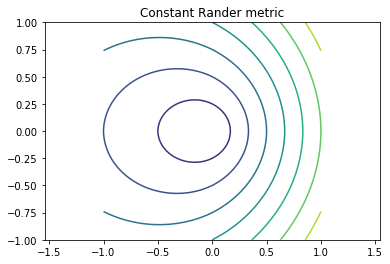

In [9]:
plt.title("Constant Rander metric"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

### 1.2 Zermelo's problem

We obtain $\times 40$ speedup at resolution $2000\times 2000$ already. The lack of causality does not seem to be a significant issue for the GPU solver. The cost of the FM-ASR adaptive stencils cannot be neglected. 

In [10]:
n=4000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'seed':[0.,0.],
    'exportValues':1,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)

In [11]:
def Drift(x,mu):
    rho = (mu-1)/(mu+1)
    mult = rho*np.prod(np.sin(x),axis=0) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

In [12]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmIn.Grid(),mu=anisotropy_bound))

In [13]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.05);

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.11849427223205566 seconds, and 157 iterations.
Post-Processing
--- gpu done, turning to cpu ---


Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 3.127 s.
Solver time (s). GPU : 0.11849427223205566, CPU : 5.384. Device acceleration : 45.43679537063306
Max |gpuValues-cpuValues| :  0.04047519288110468


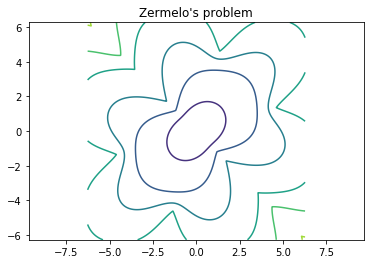

In [14]:
plt.title("Zermelo's problem"); plt.axis('equal')
plt.contour(*hfmIn.Grid(),gpuOut['values']);

In [15]:
n=200; hfmInS = hfmIn.copy() # Define a small instance for validation with multiple options
hfmInS.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)
hfmInS.update({
    'metric' : Metrics.Rander.from_Zermelo(cp.eye(2),Drift(hfmInS.Grid(),mu=anisotropy_bound)),
    'verbosity':0,
    'exportGeodesicFlow':True,
})

In [16]:
RunCompare(hfmInS,variants='basic',check=0.2)

Solver time (s). GPU : 0.023497343063354492, CPU : 0.196. Device acceleration : 8.341368616508548
Max |gpuValues-cpuValues| :  0.1749730858147469

 --- Variant {'multiprecision': True} ---


Solver time (s). GPU : 0.024497270584106445, CPU : 0.191. Device acceleration : 7.7967869662965095
Max |gpuValues-cpuValues| :  0.17496545642021566

 --- Variant {'seedRadius': 2.0} ---


Solver time (s). GPU : 0.02499842643737793, CPU : 0.188. Device acceleration : 7.520473357431021
Max |gpuValues-cpuValues| :  0.1660324307355392

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---


Solver time (s). GPU : 0.025997400283813477, CPU : 0.194. Device acceleration : 7.462284608541742
Max |gpuValues-cpuValues| :  0.16602480134100794


In [17]:
RunCompare(hfmInS,variants='ext',check=0.2)

Solver time (s). GPU : 0.0214993953704834, CPU : 0.181. Device acceleration : 8.418841408372609
Max |gpuValues-cpuValues| :  0.1749730858147469

 --- Variant {'multiprecision': True} ---


Solver time (s). GPU : 0.0269927978515625, CPU : 0.189. Device acceleration : 7.001867721876766
Max |gpuValues-cpuValues| :  0.17496545642021566

 --- Variant {'seedRadius': 2.0} ---


Solver time (s). GPU : 0.02499842643737793, CPU : 0.196. Device acceleration : 7.840493500300426
Max |gpuValues-cpuValues| :  0.1660324307355392

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---


Solver time (s). GPU : 0.020503520965576172, CPU : 0.189. Device acceleration : 9.217928975092445
Max |gpuValues-cpuValues| :  0.16602480134100794

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---


Solver time (s). GPU : 0.017998933792114258, CPU : 0.19. Device acceleration : 10.556180837958486
Max |gpuValues-cpuValues| :  0.1333967419538009

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key', 'multiprecision': True} ---


Solver time (s). GPU : 0.02248215675354004, CPU : 0.19. Device acceleration : 8.451146483981463
Max |gpuValues-cpuValues| :  0.13338911255926966

 --- Variant {'order': 2} ---


Solver time (s). GPU : 0.024487733840942383, CPU : 0.204. Device acceleration : 8.330701457515893
Max |gpuValues-cpuValues| :  0.16187108110605486

 --- Variant {'order': 2, 'multiprecision': True} ---


Solver time (s). GPU : 0.031501054763793945, CPU : 0.207. Device acceleration : 6.571208537369914
Max |gpuValues-cpuValues| :  0.16186965059458025

 --- Variant {'order': 2, 'seedRadius': 2.0} ---


Solver time (s). GPU : 0.025999069213867188, CPU : 0.204. Device acceleration : 7.84643474433277
Max |gpuValues-cpuValues| :  0.1720180636796238

 --- Variant {'order': 2, 'seedRadius': 2.0, 'multiprecision': True} ---


Solver time (s). GPU : 0.030496835708618164, CPU : 0.211. Device acceleration : 6.918750588290479
Max |gpuValues-cpuValues| :  0.1720171100053074

 --- Variant {'order': 2, 'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---


Solver time (s). GPU : 0.02197432518005371, CPU : 0.20500000000000002. Device acceleration : 9.329069189623185
Max |gpuValues-cpuValues| :  0.17932695113914754

 --- Variant {'order': 2, 'factoringRadius': 10.0, 'factoringPointChoice': 'Key', 'multiprecision': True} ---


Solver time (s). GPU : 0.022975444793701172, CPU : 0.212. Device acceleration : 9.227242471411078
Max |gpuValues-cpuValues| :  0.17954009734886434


## 2. Three dimensions

As mentioned in the introduction, the CPU variant does not handle three dimensional problems. We generalize here Zermelo's problem, for the sake of testing array broadcasting.

In [18]:
n=200
hfmIn = Eikonal.dictIn({
    'model':'Rander3',
    'seed':[0.,0.,0.],
    'exportValues':1,
    'raiseOnNonConvergence':False,
})
side = [-2.*np.pi,2.*np.pi]
hfmIn.SetRect([side,side,side],dimx=n+1)

In [19]:
hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(3),Drift(hfmIn.Grid(),mu=anisotropy_bound))

In [20]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)


Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


Running the eikonal GPU kernel


GPU kernel eikonal ran for 0.40001606941223145 seconds, and 89 iterations.
Post-Processing
